# Regression

**Prerequisites**

- scientific/applied_linalg  
- scientific/optimization  


**Outcomes**

- Recall linear regression from linear algebra  
- Know what feature engineering is and how feature engineering can be automated by neural networks  
- Understand the related concepts of overfitting and regularization  
- Understand lasso regression, its relation to linear regression  
- Understand the basics of the multi-layer perceptron  
- Use scikit-learn to fit linear regression, lasso, and multi-layer perceptron to data on housing prices near Seattle, WA  

## Introduction to Regression

The goal of regression analysis is to provide an accurate mapping from one or
more input variables (called features in machine learning or exogenous
variables in econometrics) to a continuous output variable (called the label or
target in machine learning and the endogenous variable in
econometrics)

In this lecture we will study some of the most fundamental and widely used
regression algorithms

We will follow the same general pattern when we learn each algorithm:

- Describe the mathematical foundation for the algorithm  
- Use the [scikit-learn](https://scikit-learn.org/stable/) python package to
  apply the algorithm to a real world dataset on house prices in California  

### Dataset

Let’s load the dataset and take a quick look at what our task is

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # set up plotting theme to make charts look nice
%matplotlib inline

# we will import all these here to ensure that they are loaded, but
# will usually re-import close to where they are used to make clear
# where the functions come from
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)

url = "https://storage.googleapis.com/qeds/data/kc_house_data.csv"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


This dataset contains sales prices on houses in King County (which
include Seattle),
Washington, from May 2014 to May 2015. The data comes from
`Kaggle<https://www.kaggle.com/harlfoxem/housesalesprediction>`_. Documentation
can be found at that link.

In [2]:
X = df.drop(["price", "date", "id"], axis=1).copy()
# convert everything to be a float for later on
for col in list(X):
    X[col] = X[col].astype(float)
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0
1,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,1951.0,1991.0,98125.0,47.7210,-122.319,1690.0,7639.0
2,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0
3,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0
4,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,1987.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0


In [3]:
# notice the log here!
y = np.log(df["price"])
df["log_price"] = y
y.head()

0    12.309982
1    13.195614
2    12.100712
3    13.311329
4    13.142166
Name: price, dtype: float64

While we will be using all the variables in `X` in our regression models,
we will explain some algorithms using only the `sqft_living` variable

Here’s what the log house price looks like against `sqft_living`:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


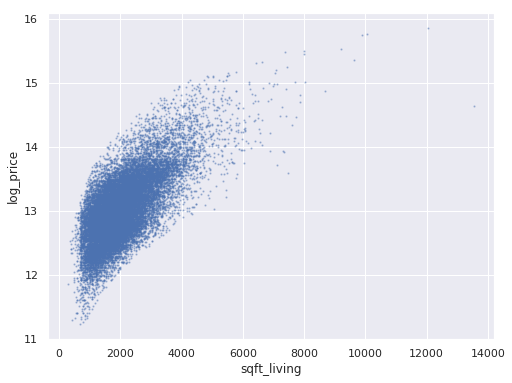

In [4]:
def sqft_scatter(df, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x="sqft_living" , y="log_price", alpha=0.35, s=1.5, ax=ax)

    return ax

sqft_scatter(df);

## Linear Regression

Let’s dive in by studying the [“Hello World”](https://en.wikipedia.org/wiki/%22Hello,_World!%22_program) of regression
algorithms: linear regression

Suppose we would like to predict the log of the sale price of a home, given
only the livable square footage of the home

The linear regression model for this situation is

$$
\log(\text{price}) = \beta_0 + \beta_1 \text{sqft_living} + \epsilon
$$

$ \beta_0 $ and $ \beta_1 $ are called parameters (also coefficients or
weights) and it is the task of the machine learning algorithm to find the values
for the parameters that best fit the data

$ \epsilon $ is the error term. It would be unusual for the observed
$ \log(\text{price}) $ will be an exact linear function of
$ \text{sqft_living} $. The error term captures the deviation of
$ \log(\text{price}) $ from a linear function of $ \text{sqft_living} $.

The linear regression algorithm will choose the parameters to minimize the
*mean squared error* (MSE) function, which for our example is written

$$
\frac{1}{N} \sum_{i=1}^N \left(\log(\text{price}_i) - (\beta_0 + \beta_1 \text{sqft_living}_i) \right)^2
$$

The output of this algorithm is the straight line (hence linear) that passes as
close to the points on our scatter chart as possible

The `sns.lmplot` function below will plot our scatter chart and draw the
optimal linear regression line through the data

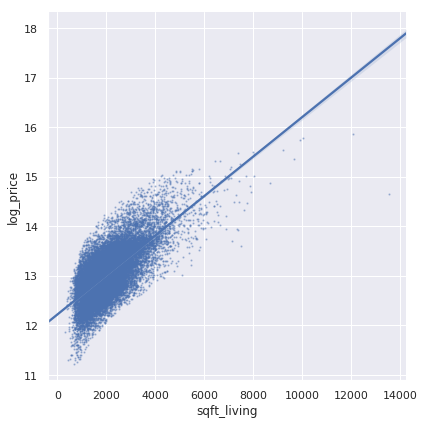

In [5]:
sns.lmplot(
    data=df, x="sqft_living", y="log_price", height=6,
    scatter_kws=dict(s=1.5, alpha=0.35)
);

Let’s use `sklearn` to replicate the figure ourselves

First we fit the model

In [6]:
# import
from sklearn import linear_model

# construct the model instance
sqft_lr_model = linear_model.LinearRegression()

# fit the model
sqft_lr_model.fit(X[["sqft_living"]], y)

# print the coefficients
beta_0 = sqft_lr_model.intercept_
beta_1 = sqft_lr_model.coef_

print(f"Fit model: log(price) = {beta_0} + {beta_1} sqft_living")

Fit model: log(price) = 12.218464096380853 + [0.00039875] sqft_living


Then we construct the plot

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


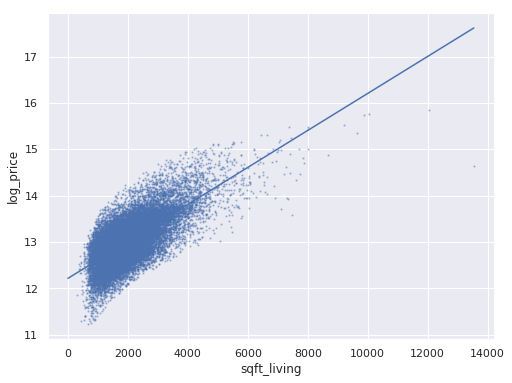

In [7]:
ax = sqft_scatter(df)

# points for the line
x = np.array([0, df["sqft_living"].max()])
ax.plot(x, beta_0 + beta_1*x)

We can call the `predict` method on our model to evaluate the model at
arbitrary points

For example, we can ask the model to predict the sale price of a 5,000 square
foot home

In [8]:
# note, the argument needs to be two-dimensional, you'll see why shortly
logp_5000 = sqft_lr_model.predict([[5000]])[0]
print(f"The model predicts a 5,000 sq. foot home would cost {np.exp(logp_5000)} dollars")

The model predicts a 5,000 sq. foot home would cost 1486889.318775181 dollars


### Multivariate linear regression

The example we have been working with is referred to as univariate linear
regression because we used a single feature

In practice more features would be used

Suppose that in addition to `sqft_living` we also wanted to use the `bathrooms` variable

In this case the linear regression model is

$$
\log(\text{price}) = \beta_0 + \beta_1 \text{sqft_living} +
\beta_2 \text{bathrooms} + \epsilon
$$

We could keep adding one variable at a time and adding a new $ \beta_{j} $ coefficient for the $ j $ th variable, but there’s an easier way

Let’s write this equation in vector/matrix form as

$$
\underbrace{\begin{bmatrix} \log(\text{price}_1) \\ \log(\text{price}_2) \\ \vdots \\ \log(\text{price}_N)\end{bmatrix}}_Y = \underbrace{\begin{bmatrix} 1 & \text{sqft_living}_1 & \text{bathrooms}_1 \\ 1 & \text{sqft_living}_2 & \text{bathrooms}_2 \\ \vdots & \vdots & \vdots \\ 1 & \text{sqft_living}_N & \text{bathrooms}_N \end{bmatrix}}_{X} \underbrace{\begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \end{bmatrix}}_{\beta} + \epsilon
$$

Notice that we can add as many columns to $ X $ as we’d like and the linear
regression model will still be written $ Y = X \beta + \epsilon $

The mean squared error loss function for the general model is

$$
\frac{1}{N} \sum_{i=1}^N (y_i - X_i \beta)^2 = \frac{1}{N} {|| y - X \beta||_2}^2
$$

where $ || \cdot ||_2 $ is the [l2-norm](http://mathworld.wolfram.com/L2-Norm.html)

Let’s fit the linear regression model using all the columns in `X`

In [9]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

We just fit a model with 18 variables and it was just as fast and easy as
fitting the model with 1 variable!

It is difficult to visualize a 18-dimensional model, but just so we can see the
difference the extra features made let’s make the log price vs `sqft_living`
one more time, including the prediction from both of our linear models

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


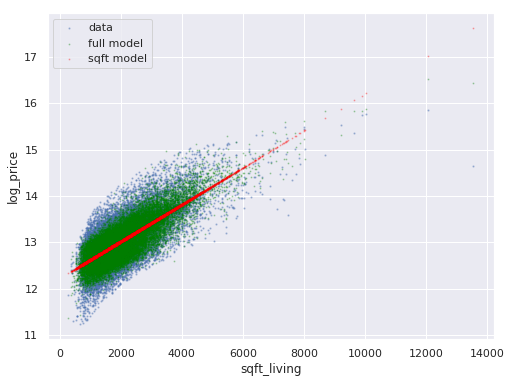

In [10]:
ax = sqft_scatter(df)

def sqft_scatter_model(mod, X, ax=None, color="green"):
    if ax is None:
        _, ax = plt.subplots()

    ax.scatter(X["sqft_living"], mod.predict(X), c=color, alpha=0.25, s=1)
    return ax

sqft_scatter_model(lr_model, X, ax, color="green")
sqft_scatter_model(sqft_lr_model, X[["sqft_living"]], ax, color="red")
ax.legend(["data", "full model", "sqft model"])

### Nonlinear relationships in linear regression

While it sounds like an oxymoron, it is possible to include non-linear features
in a linear regression model

The distinguishing feature of the linear regression model is that the each
prediction is generated by taking the dot product (a linear operator) between a
feature vector (one row of $ X $) and a coefficient vector ($ \beta $)

There is, however, no restriction on what element we include in our feature
vector

Let’s consider an example…

Starting from the `sqft_living` only model, suppose we have a hunch that we
should also include the *percent of square feed above ground*

This last variable can be computed as `sqft_above / sqft_living`

This second feature is nonlinear, but could easily be included as a column in
`X`

Let’s see this in action

In [11]:
X2 = X[["sqft_living"]].copy()
X2["pct_sqft_above"] = X["sqft_above"] / X["sqft_living"]

sqft_above_lr_model = linear_model.LinearRegression()
sqft_above_lr_model.fit(X2, y)

new_mse = metrics.mean_squared_error(y, sqft_above_lr_model.predict(X2))
old_mse = metrics.mean_squared_error(y, sqft_lr_model.predict(X2[["sqft_living"]]))
print(f"The mse changed from {old_mse} to {new_mse} by including our new feature")

The mse changed from 0.14326910852241476 to 0.14303867743053914 by including our new feature


The process of determining what columns belong in $ X $ is called *feature
engineering* and is a large part of a machine learning practitioner’s job

You may recall from (or will see in) your econometrics course(s) that
the choice of which control variables to include in a regression model
is an important part of applied research

### Interpretability

Before moving to our next regression model, we want to touch on the idea of
the **interpretability** of models

A model that is interpretable is a model for which we can analyze the
coefficients and explain why it makes its predictions

Recall $ \beta_0 $ and $ \beta_1 $ from the univariate model

The interpretation of the model is that $ \beta_0 $ captures the notion of
the average or starting house price and $ \beta_1 $ is the additional value
per square foot

Concretely we have

In [12]:
beta_0, beta_1

(12.218464096380853, array([0.00039875]))

which means that our model predicts the log price of a house to be 12.22, plus
an additional 0.0004 for every square foot

Some more exotic machine learning methods are potentially more accurate, but
less interpretable

The accuracy vs interpretably tradeoff is a hot discussion topic, especially as
it relates to things like ethics in machine learning and is something you
should be aware of as continue to learn about these techniques

## Lasso Regression

Lasso regression is very closely related to linear regression

The lasso model also generates predictions using $ y = X \beta $, but it
optimizes over a slightly different loss function

The optimization problem solved by lasso regression can be written

$$
\min_{\beta} {|| X \beta - y||_2}^2 + \underbrace{\alpha {|| \beta ||_1}}_{\text{new part}}
$$

where $ || a ||_1 = \sum_{i=1}^N | a_i| $ is the [l1-norm](http://mathworld.wolfram.com/L1-Norm.html) and $ \alpha $ is called the regularization parameter

The additional term penalizes large coefficients and in practice has the effect
of setting coefficients to zero for features that are not informative about the
target

Let’s see an example of what this looks like using the full feature set in
`X`

In [13]:
lasso_model = linear_model.Lasso()
lasso_model.fit(X, y)

lasso_coefs = pd.Series(dict(zip(list(X), lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(list(X), lr_model.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs

,lasso,linreg
bedrooms,-0.000000e+00,-1.220820e-02
bathrooms,0.000000e+00,6.912370e-02
sqft_living,3.007615e-04,9.573470e-05
sqft_lot,2.736772e-07,4.711823e-07
floors,0.000000e+00,7.515336e-02
waterfront,0.000000e+00,3.711951e-01
view,0.000000e+00,6.040466e-02
condition,0.000000e+00,6.263658e-02
grade,0.000000e+00,1.589338e-01
sqft_above,-0.000000e+00,4.022408e-05


Notice that many of the coefficients from the lasso regression have been set to
zero

The intuition here is that the corresponding features must not have provided
enough predictive power to be worth considering alongside the other features

The default value for the $ \alpha $ parameter is 1.0

Larger values of the parameter will cause coefficients to shrink (and maybe
additional ones to be thrown out)

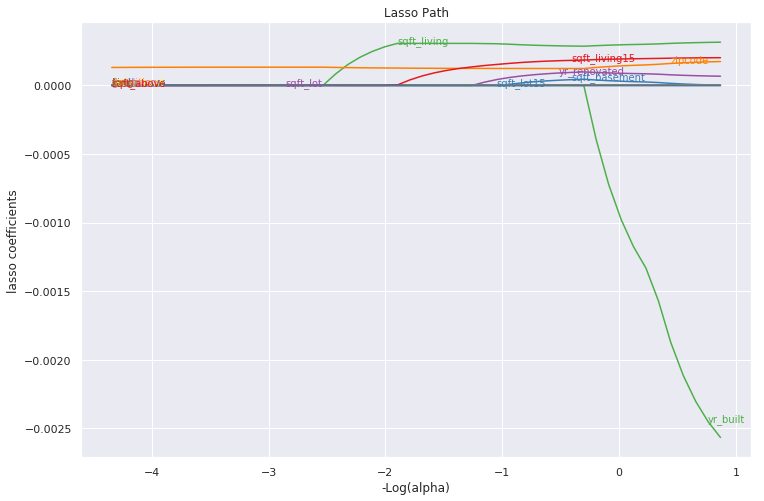

In [14]:
# Compute lasso for many alphas (the lasso path)
from itertools import cycle
alphas = np.exp(np.linspace(10, -2, 50))
alphas, coefs_lasso, _ = linear_model.lasso_path(X, y, alphas=alphas, fit_intercept=True, max_iter=10000)

# plotting
fig = plt.figure(figsize=(12, 8))
colors = cycle(sns.color_palette("Set1", 16))
log_alphas = -np.log10(alphas)
for coef_l, c, name in zip(coefs_lasso, colors, list(X)):
       plt.plot(log_alphas, coef_l, c=c)
       plt.xlabel('-Log(alpha)')
       plt.ylabel('lasso coefficients')
       plt.title('Lasso Path')
       plt.axis('tight')
       maxabs = np.max(np.abs(coef_l))
       i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
       xnote = log_alphas[i]
       ynote = coef_l[i]
       plt.annotate(name, (xnote, ynote), color=c)

### Overfitting and regularization

You might be asking yourself “Why would we ever want to throw variables out,
can’t that only hurt our model?”

The primary answer is to help us avoid a common issue called **overfitting**

Overfitting refers to a model that specializes its coefficients too much on the
data it was trained on, and then performs poorly when predicting on data
outside the training set

The extreme example of overfitting is a model that can perfectly memorize the
training data, but can do no better than just randomly guess when predicting
on a new observation

The techniques applied to reduce overfitting are known as **regularization**

Regularization an attempt to limit a model’s ability to specialize too narrowly
on training data (e.g. limit overfitting) by penalizing extreme values of the
model’s parameters

The additional term in the lasso regression loss function ($ \alpha ||\beta||_1 $)
is a form of regularization

Let’s demonstrate the overfitting and regularization phenomenon on our housing
price data as follows:

1. Split the data set into training and testing subsets. We will use the first 50 observations for training, and the rest for testing  
1. Fit the linear regression model and report MSE on training and testing datasets  
1. Fit the lasso model and report the same statistics  

In [15]:
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

split = 50
X_train = X.iloc[:split, :]
X_test = X.iloc[split:, :]
y_train = y.iloc[:split]
y_test = y.iloc[split:]

fit_and_report_mses(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

{'mse_train': 0.05545627171577233, 'mse_test': 0.6705205330642532}

In [16]:
fit_and_report_mses(linear_model.Lasso(), X_train, X_test, y_train, y_test)

{'mse_train': 0.10629195024125096, 'mse_test': 0.2910434823708493}

Notice how the MSE on the training dataset was smaller for the linear model
without the regularization, but that the MSE on the test dataset was much
higher

This is a strong indication that the linear regression model was
overfitting

The regularization parameter has a large impact on overfitting

Text(-2.368878992199555, 0.2249868810554537, 'train')

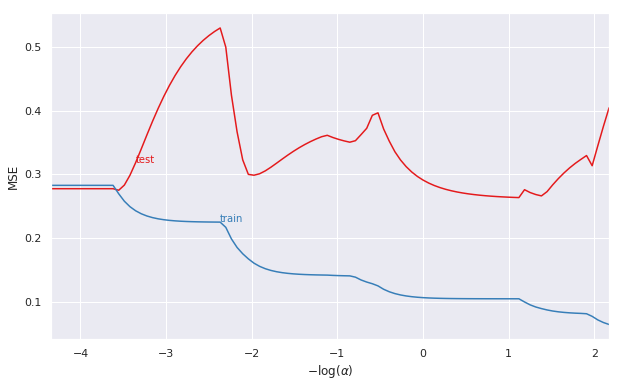

In [17]:
alphas = np.exp(np.linspace(10, -5, 100))
mse = pd.DataFrame([fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=50000),
                           X_train, X_test, y_train, y_test)
                    for alpha in alphas])
mse["log_alpha"] = -np.log10(alphas)
fig, ax = plt.subplots(figsize=(10,6))
colors = sns.color_palette("Set1", 16)
mse.plot(x="log_alpha", y="mse_test", c=colors[0], ax=ax)
mse.plot(x="log_alpha", y="mse_train", c=colors[1], ax=ax)
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
ax.get_legend().remove()
ax.annotate("test",(mse.log_alpha[15], mse.mse_test[15]),color=colors[0])
ax.annotate("train",(mse.log_alpha[30], mse.mse_train[30]),color=colors[1])

### Holdout

Another common technique that practitioners use to avoid overfitting is called
*holdout*

We demonstrated an extreme example of applying holdout above when we used only
the first 50 observations to train our models

In general, good practice is to split the entire dataset into a training subset
and testing or validation subset

The splitting should be done randomly and should leave enough data in the
training dataset to produce a good model, but also enough in the validation
subset to determine the degree of overfitting

There aren’t hard and fast rules for how much data to put in each subset, but a
reasonable default would be to use about %75 of the data for training and the
rest for testing

The `sklearn` function `model_selection.train_test_split` will do this for you:

In [ ]:
# note test_size=0.25 is the default value, but is shown here so you
# can see how to change it
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

## Neural Networks

The final regression algorithm we will talk about in this lecture is a type of
neural network

Based on your interest in this course, our strong prior is that you have
probably heard about neural networks in the news or social media

The purpose of this section is not to give an exhaustive overview of the topic,
but instead to introduce you to a particular neural network model and present
it from a different perspective that hopefully complement materials you may run
into elsewhere

### Mathematical Background

If linear regression is the [“Hello World”](https://en.wikipedia.org/wiki/%22Hello,_World!%22_program) of regression
algorithms, then the multi-layer perceptron (MLP) is the hello world of neural
networks

We’ll start with a single (hidden) layer MLP and then build up to the general form

The prediction function for a single layer MLP is

$$
y = f_1(X w_1 + b_1) w_2 + b_2
$$

In words what we have here is *nested linear regression* (the $ (\cdot) w_i + b_i $
parts), separated by an *activation function* (the $ f_1 $)

Let’s unpack what happens, starting from our $ N_\text{samples} \times
N_\text{features} $ feature matrix $ X $

1. First, $ X $ is multiplied by a coefficient matrix $ w_1 $. $ w_1 $ is often called the *weight matrix* or *weights* for short and has dimension $ N_{\text{features}} \times N_1 $
1. The vector $ b_1 $ is added to each row. $ b_1 $ is often called the *bias vector* or *bias* for short  and has dimension $ N_1 \times 1 $
1. The function $ f_1 $ is then applied. Typically $ f_1 $ a non-linear function that is applied separately to each element. $ f_1 $ is called the *activation function*
1. The output is then multiplied by a weight matrix $ w_2 $ with dimension $ N_1 \times 1 $
1. Finally a scalar $ b_2 $ is added to each row to generate the final prediction with dimension $ N_{\text{samples}} \times 1 $

The way we might write this in python is:

```python
y = f(X@w1 + b1)@w2 + b2
```


In order to build an $N$-hidden layer MLP we will *nest* additional linear regressions separated by activation functions

The equation for this case is difficult to express, but has the following form

$$
y = f_{\cdots} \left(f_2(f_1(X w_1 + b_1) w_2 + b_2) w_{\cdots} + b_{\cdots} \right) w_{N+1} + b_{N+1}
$$

where the $ \cdots $ represents layers 3 to $ N $

Notice the pattern of a linear regression ($ (\cdot) w + b $),
followed by applying an activation function ($ f $) at each step

The loss or error function typically used when using an MLP for regression is
our now familiar mean squared error loss function:

$$
{||y - \hat{y}||_2}^2
$$

where $ \hat{y} $ is the output of the neural network.

We are nearly ready to test out a MLP on our housing data, but there are a few
more talking points to cover:

- It has been proven that MLPs are universal approximators, meaning they are
  theoretically capable of approximating any function  
- It is crucial that the activation functions are non-linear. If they were not
  the MLP would be combining linear combinations of linear combinations and
  would always be linear  
- The hidden layer structure of a MLP allows it to do automatic feature engineering.
  This is in contrast to the example we had above where we manually engineered
  the square feet above ground feature  

### Application

Ok, now let’s try out our first neural network!

In [ ]:
from sklearn import neural_network

# two hidden layers, with N1=20 and N2=15
nn_model = neural_network.MLPRegressor((30, 20))
nn_model.fit(X, y)

ax = sqft_scatter(df)
sqft_scatter_model(nn_model, X, ax=ax)

Wow! That plot looks horrible, let’s check the MSE

In [ ]:
mse_nn = metrics.mean_squared_error(y, nn_model.predict(X))
mse_nn / metrics.mean_squared_error(y, lr_model.predict(X))

So… after all that talk about neural networks begin able to do anything, we
get a mean squared error that is tens of thousands of times larger than the
MSE from a linear regression!

### Input scaling

The issue here is that neural networks are extremely sensitive to the scale
(both relative and absolute) of the input features

The reasons for why are a bit beyond the scope of this lecture, but the main
idea is the training procedure will pay too much attention to relatively larger
features (relative scale) and become unstable if features are very large
(absolute scale)

A common technique to overcome this issue is to scale each variable so that the
observations have mean 0 and standard deviation 1

This is known as scaling or normalizing the inputs

If we do decide to scale our variables, we must remember to apply the same
transformation at prediction time that we applied when we fit the model

In practice this means that we must do three things:

1. Store the mean and standard deviation of each feature in the training set  
1. Subtract each feature’s mean from the training data and then divide by the feature’s standard deviation before fitting  
1. Subtract the *training data’s* mean and divide by *training data’s* standard deviation for all prediction inputs  


This is a tedious and somewhat error-prone process as it is easy to forget to
apply the transformation to the prediction data

Thankfully scikit-learn has a way to automate the process and ensure that it is
always applied

Let’s see an example:

In [ ]:
from sklearn import preprocessing, pipeline

# the pipeline defines any number of steps that will be applied
# to transform the `X` data and then a final step that is a model
# we can use for prediction
nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),  # this will do the input scaling
    neural_network.MLPRegressor((30, 20))  # put your favorite model here
)

# we can now use `model` like we have used our other models all along
# call fit
nn_scaled_model.fit(X, y)

# call predict
mse_nn_scaled = metrics.mean_squared_error(y, nn_scaled_model.predict(X))

print(f"Unscaled mse {mse_nn}")
print(f"Scaled mse {mse_nn_scaled}")

There we have it, much better

This is the smallest MSE we have seen so far

A scatter plot of the predictions looks very similar to the

In [ ]:
ax = sqft_scatter(df)
sqft_scatter_model(nn_scaled_model, X, ax=ax)

### Tradeoffs

So we’ve seen that neural networks are very flexible and can approximate highly
nonlinear functions

However, there are tradeoffs to using them

We’ll discuss a few of them here

- **Interpretability**: unlike linear regression or lasso, neural networks are not interpretable. We could look at the $ w $ matrices or $ b $ vectors, but due to the nested composition and nonlinear activation functions it is very difficult to interpret just how each coefficient impacts the output. In settings like making economic policy recommendations or suggestion decisions with potentially ethical consequences (e.g. approving loans, screening) the lack of interpretability can be a non-starter  
- **Efficiency/time**: Neural networks require more computational power to evaluate (generate predictions) and are orders of magnitude more expensive to train than classical machine learning methods. Depending on the computational resources and accuracy requirements needed  
- **Automated feature engineering**: the nested linear regressions allows neural networks to learn features of the data that are composed of arbitrary linear combinations of the original feature set. The non-linear activation functions allow the network to learn arbitrary non-linear features. Manual feature engineering is based largely on the researchers intuition and a fair amount of trial and error. Coming up with the right features that allow for more explanatory power without overfitting is very difficult. Neural networks automate that process by having the data itself guide the training process to select features that satisfy accuracy and regularization conditions.  
- **Overfitting**: because of their great flexibly and explanatory power it is very easy to overfit when using neural networks. There are various approaches to regularization when training neural networks, and these should be studied and evaluated when building networks that will be used for decision making purposes  

## Potential Exercises: TODO

- See if scaling the input variables makes a difference for the accuracy fo the lasso or linear regression fits  
- Have students experiment with other regression classes like `sklearn.tree.DecisionTreeRegressor`  
- Apply the techniques to a different dataset  
- Explore regularization for neural networks – perhaps plot a histogram of coefficient values as a and compare the histogram for different levels of regularization parameters  
- Explore different hidden layer sizes  
- redo the train/test overfitting exercise with the neural network. Find regularization parameters that avoids extreme overfitting  